# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 3: Multiple Linear Regression and Polynomial Regression 

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>

<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to get you familiarized with Multiple Linear Regression. We have learned how to model data with kNN Regression and Simple Linear Regression and our goal now is to dive deep into Linear Regression.

Specifically, we will: 
    
- Load in the titanic dataset from seaborn
- Learn a few ways to plot **distributions** of variables using seaborn
- Learn about different **kinds of variables** including continuous, categorical and ordinal
- Perform single and multiple linear regression
- Learn about **interaction** terms
- Understand how to **interpret coefficients** in linear regression
- Look at **polynomial** regression
- Understand the **assumptions** being made in a linear regression model
- (Extra): look at some cool plots to raise your EDA game

![meme](../fig/meme.png)

In [2]:
# Data and Stats packages
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Extending Linear Regression

## Working with the Titanic Dataset from Seaborn

For our dataset, we'll be using the passenger list from the Titanic, which famously sank in 1912. Let's have a look at the data. Some descriptions of the data are at https://www.kaggle.com/c/titanic/data, and here's [how seaborn preprocessed it](https://github.com/mwaskom/seaborn-data/blob/master/process/titanic.py).

The task is to build a regression model to **predict the fare**, based on different attributes.

Let's keep a subset of the data, which includes the following variables: 

- age
- sex
- class
- embark_town
- alone
- **fare** (the response variable)

In [3]:
# Load the dataset from seaborn 
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [6]:
# checking for null values
chosen_vars = ['age', 'sex', 'class', 'embark_town', 'alone', 'fare']
titanic = titanic[chosen_vars]

**Exercise**: check the datatypes of each column and display the statistics (min, max, mean and any others) for all the numerical columns of the dataset.

In [9]:
## your code here
titanic.info()
print(titanic.head())
titanic.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
age            714 non-null float64
sex            891 non-null object
class          891 non-null category
embark_town    889 non-null object
alone          891 non-null bool
fare           891 non-null float64
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.8+ KB
    age     sex  class  embark_town  alone     fare
0  22.0    male  Third  Southampton  False   7.2500
1  38.0  female  First    Cherbourg  False  71.2833
2  26.0  female  Third  Southampton   True   7.9250
3  35.0  female  First  Southampton  False  53.1000
4  35.0    male  Third  Southampton   True   8.0500


,age,fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


**Exercise**: drop all the non-null *rows* in the dataset. Is this always a good idea?

In [10]:
## your code here
## NOT ALWAYS. Especially if there are too many NaNs. This might make the dataset too small
titanic_na = titanic.dropna()
print(len(titanic_na), len(titanic))

712 891


In [11]:
titanic = titanic_na

Now let us visualize the response variable. A good visualization of the distribution of a variable will enable us to answer three kinds of questions:

- What values are central or typical? (e.g., mean, median, modes)
* mean = 32.204208
- What is the typical spread of values around those central values? (e.g., variance/stdev, skewness)
* Sigma = 49.69; Right-skewed
- What are unusual or exceptional values (e.g., outliers)

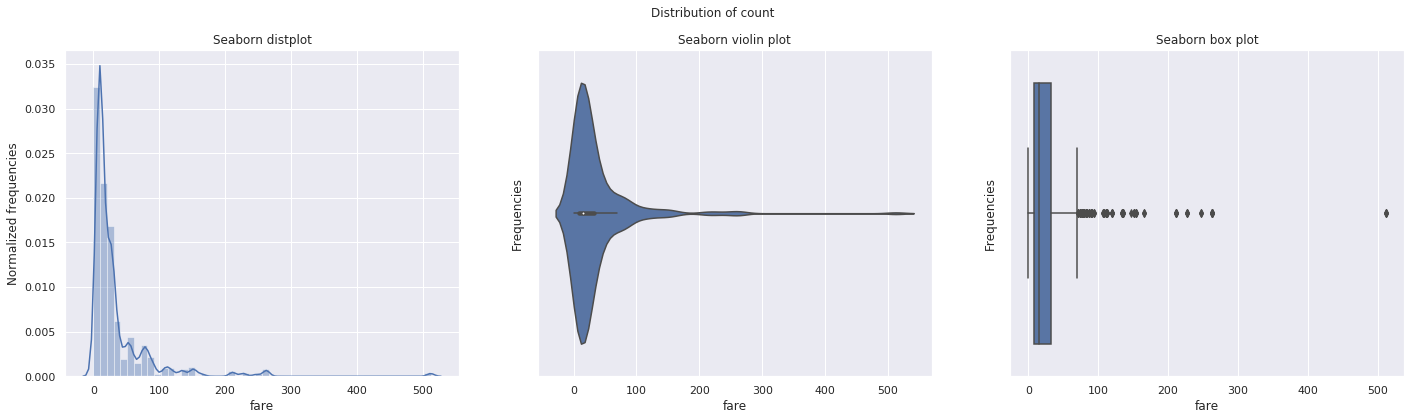

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
ax = ax.ravel()

sns.distplot(titanic['fare'], ax=ax[0])
ax[0].set_title('Seaborn distplot')
ax[0].set_ylabel('Normalized frequencies')

sns.violinplot(x='fare', data=titanic, ax=ax[1])
ax[1].set_title('Seaborn violin plot')
ax[1].set_ylabel('Frequencies')

sns.boxplot(x='fare', data=titanic, ax=ax[2])
ax[2].set_title('Seaborn box plot')
ax[2].set_ylabel('Frequencies')
fig.suptitle('Distribution of count');

How do we interpret these plots?

## Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split

titanic_train, titanic_test = train_test_split(titanic, train_size=0.7, random_state=99)
titanic_train = titanic_train.copy()
titanic_test = titanic_test.copy()
print(titanic_train.shape, titanic_test.shape)

(498, 6) (214, 6)


## Simple one-variable OLS

**Exercise**: You've done this before: make a simple model using the OLS package from the statsmodels library predicting **fare** using **age** using the training data. Name your model `model_1` and display the summary

In [14]:
from statsmodels.api import OLS
import statsmodels.api as sm

In [66]:
# Your code here
model_1 = sm.OLS(titanic_train['fare'], sm.add_constant(titanic_train['age'])).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     6.387
Date:                Wed, 18 Dec 2019   Prob (F-statistic):             0.0118
Time:                        18:11:57   Log-Likelihood:                -2707.6
No. Observations:                 498   AIC:                             5419.
Df Residuals:                     496   BIC:                             5428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8467      5.825      3.579      0.000       9.401      32.292
age            0.4464      0.177      2.527      0.012       0.099       0.793
==============================================================================
Omnibus:                      534.721   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25194.011
Skew:                           4.956   Prob(JB):                         0.00
Kurtosis:                      36.405   Cond. No.                         77.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Dealing with different kinds of variables

In general, you should be able to distinguish between three kinds of variables: 

1. Continuous variables: such as `fare` or `age`
2. Categorical variables: such as `sex` or `alone`. There is no inherent ordering between the different values that these variables can take on. These are sometimes called nominal variables. Read more [here](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-interval-variables/). 
3. Ordinal variables: such as `class` (first > second > third). There is some inherent ordering of the values in the variables, but the values are not continuous either. 

*Note*: While there is some inherent ordering in `class`, we will be treating it like a categorical variable.

In [19]:
titanic_orig = titanic_train.copy()

Let us now examine the `sex` column and see the value counts.

In [20]:
titanic_train['sex'].value_counts()

male      316
female    182
Name: sex, dtype: int64

**Exercise**: Create a column `sex_male` that is 1 if the passenger is male, 0 if female. The value counts indicate that these are the two options in this particular dataset. Ensure that the datatype is `int`.

In [41]:
# your code here
titanic_train['sex_male'] = titanic_train.apply(lambda row: 1 if row.sex == 'male' else 0, axis=1)
titanic_train.head()

,age,sex,class,embark_town,alone,fare,sex_male
278,7.0,male,Third,Queenstown,False,29.1250,1
177,50.0,female,First,Cherbourg,True,28.7125,0
438,64.0,male,First,Southampton,False,263.0000,1
452,30.0,male,First,Cherbourg,True,27.7500,1
93,26.0,male,Third,Southampton,False,20.5750,1


Do we need a `sex_female` column, or a `sex_others` column? Why or why not?

Now, let us look at `class` in greater detail.

In [42]:
titanic_train['class_Second'] = (titanic_train['class'] == 'Second').astype(int)
titanic_train['class_Third'] = 1 * (titanic_train['class'] == 'Third') # just another way to do it

In [43]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 278 to 805
Data columns (total 9 columns):
age             498 non-null float64
sex             498 non-null object
class           498 non-null category
embark_town     498 non-null object
alone           498 non-null bool
fare            498 non-null float64
sex_male        498 non-null int64
class_Second    498 non-null int64
class_Third     498 non-null int64
dtypes: bool(1), category(1), float64(2), int64(3), object(2)
memory usage: 52.2+ KB


In [45]:
# This function automates the above:
titanic_train = titanic_orig
titanic_train_copy = pd.get_dummies(titanic_train, columns=['sex', 'class'], drop_first=True)
titanic_train_copy.head()

,age,embark_town,alone,fare,sex_male,class_Second,class_Third
278,7.0,Queenstown,False,29.1250,1,0,1
177,50.0,Cherbourg,True,28.7125,0,0,0
438,64.0,Southampton,False,263.0000,1,0,0
452,30.0,Cherbourg,True,27.7500,1,0,0
93,26.0,Southampton,False,20.5750,1,0,1


## Linear Regression with More Variables

**Exercise**: Fit a linear regression including the new sex and class variables. Name this model `model_2`. Don't forget the constant!

In [67]:
# your code here
model_2 = sm.OLS(titanic_train_copy['fare'],
        sm.add_constant(titanic_train_copy[['age', 'sex_male', 'class_Second', 'class_Third']])).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     77.68
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           4.62e-51
Time:                        18:12:04   Log-Likelihood:                -2589.1
No. Observations:                 498   AIC:                             5188.
Df Residuals:                     493   BIC:                             5209.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          114.8944      7.132     16.109      0.000     100.881     128.908
age             -0.3615      0.152     -2.371      0.018      -0.661      -0.062
sex_male        -8.6374      4.242     -2.036      0.042     -16.972      -0.303
class_Second   -77.5803      5.792    -13.395      0.000     -88.960     -66.201
class_Third    -86.7392      5.414    -16.021      0.000     -97.377     -76.101
==============================================================================
Omnibus:                      593.079   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51755.735
Skew:                           5.628   Prob(JB):                         0.00
Kurtosis:                      51.657   Cond. No.                         155.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpreting These Results

1. Which of the predictors do you think are important? Why?
2. All else equal, what does being male do to the fare?

### Going back to the example from class

![male_female](../fig/male_female.png)

3. What is the interpretation of $\beta_0$ and $\beta_1$?

In [68]:
print(model_2.params.sex_male)  # Being male reduces the fare by 8.6
print(model_2.params.age)  # Age affects little on the fare
print(model_2.params.class_Second)  # Buying Second or Third class tickets
print(model_2.params.class_Third)   # Significantly reduces fare

-8.637383567846362
-0.36150865393269
-77.58026863219926
-86.73924698157964


## Exploring Interactions

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


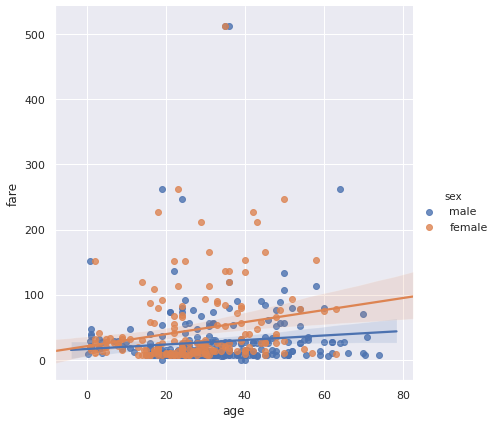

In [55]:
sns.lmplot(x="age", y="fare", hue="sex", data=titanic_train, size=6)

The slopes seem to be different for male and female. What does that indicate?

Let us now try to add an interaction effect into our model.

In [57]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic_train = titanic_train_copy
titanic_train['sex_male_X_age'] = titanic_train['age'] * titanic_train['sex_male']

model_3 = sm.OLS(
    titanic_train['fare'],
    sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age']])
).fit()
model_3.summary()

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     63.53
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           4.36e-51
Time:                        18:02:54   Log-Likelihood:                -2586.7
No. Observations:                 498   AIC:                             5185.
Df Residuals:                     492   BIC:                             5211.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            103.7450      8.784     11.811      0.000      86.487     121.003
age                0.0530      0.245      0.217      0.829      -0.428       0.534
sex_male           9.5944      9.441      1.016      0.310      -8.955      28.144
class_Second     -77.7996      5.771    -13.481      0.000     -89.139     -66.460
class_Third      -86.8314      5.394    -16.097      0.000     -97.430     -76.232
sex_male_X_age    -0.6373      0.295     -2.160      0.031      -1.217      -0.057
==============================================================================
Omnibus:                      596.406   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53218.035
Skew:                           5.676   Prob(JB):                         0.00
Kurtosis:                      52.355   Cond. No.                         244.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**What happened to the `age` and `male` terms?**

In [60]:
print(model_3.params.age, model_3.params.sex_male)

0.05304429567245317 9.594415346086894


In [58]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic_train['sex_male_X_class_Second'] = titanic_train['age'] * titanic_train['class_Second']
titanic_train['sex_male_X_class_Third'] = titanic_train['age'] * titanic_train['class_Third']

model_4 = sm.OLS(
    titanic_train['fare'],
    sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 
                             'sex_male_X_class_Second', 'sex_male_X_class_Third']])
).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     47.04
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           6.13e-51
Time:                        18:03:11   Log-Likelihood:                -2582.8
No. Observations:                 498   AIC:                             5182.
Df Residuals:                     490   BIC:                             5215.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     129.6280     12.766     10.154      0.000     104.545     154.711
age                        -0.6343      0.347     -1.827      0.068      -1.317       0.048
sex_male                    9.5493      9.386      1.017      0.309      -8.892      27.991
class_Second             -109.2283     14.872     -7.344      0.000    -138.450     -80.007
class_Third              -120.1595     13.266     -9.058      0.000    -146.225     -94.094
sex_male_X_age             -0.6169      0.294     -2.102      0.036      -1.194      -0.040
sex_male_X_class_Second     0.8600      0.399      2.156      0.032       0.076       1.644
sex_male_X_class_Third      0.9617      0.359      2.682      0.008       0.257       1.666
==============================================================================
Omnibus:                      599.639   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54799.850
Skew:                           5.721   Prob(JB):                         0.00
Kurtosis:                      53.100   Cond. No.                         483.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Polynomial Regression 

![poly](../fig/poly.png)

Perhaps we now believe that the fare also depends on the square of age. How would we include this term in our model?

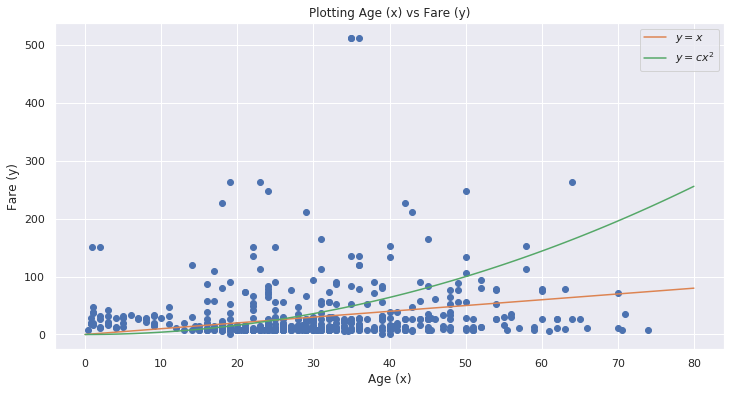

In [62]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(titanic_train['age'], titanic_train['fare'], 'o')
x = np.linspace(0,80,100)
ax.plot(x, x, '-', label=r'$y=x$')
ax.plot(x, 0.04*x**2, '-', label=r'$y=c x^2$')
ax.set_title('Plotting Age (x) vs Fare (y)')
ax.set_xlabel('Age (x)')
ax.set_ylabel('Fare (y)')
ax.legend();

**Exercise**: Create a model that predicts fare from all the predictors in `model_4` + the square of age. Show the summary of this model. Call it `model_5`. Remember to use the training data, `titanic_train`.

In [64]:
# your code here
titanic_train['age_squared'] = titanic_train['age']**2

model_5 = sm.OLS(
    titanic_train['fare'],
    sm.add_constant(titanic_train[['age', 'age_squared', 'sex_male', 'class_Second', 'class_Third',
                                   'sex_male_X_age', 'sex_male_X_class_Second', 'sex_male_X_class_Third']])
).fit()
model_5.summary()

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     41.23
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           3.04e-50
Time:                        18:08:13   Log-Likelihood:                -2582.4
No. Observations:                 498   AIC:                             5183.
Df Residuals:                     489   BIC:                             5221.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     136.4723     15.037      9.076      0.000     106.928     166.017
age                        -1.0850      0.628     -1.729      0.084      -2.318       0.148
age_squared                 0.0065      0.008      0.862      0.389      -0.008       0.021
sex_male                   11.8545      9.762      1.214      0.225      -7.325      31.034
class_Second             -112.2640     15.287     -7.344      0.000    -142.301     -82.227
class_Third              -123.9552     13.981     -8.866      0.000    -151.426     -96.485
sex_male_X_age             -0.6938      0.307     -2.261      0.024      -1.297      -0.091
sex_male_X_class_Second     0.9501      0.412      2.304      0.022       0.140       1.760
sex_male_X_class_Third      1.0817      0.385      2.812      0.005       0.326       1.838
==============================================================================
Omnibus:                      603.373   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56317.736
Skew:                           5.777   Prob(JB):                         0.00
Kurtosis:                      53.800   Cond. No.                     1.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Looking at All Our Models: Model Selection

What has happened to the $R^2$ as we added more features? Does this mean that the model is better? (What if we kept adding more predictors and interaction terms? **In general, how should we choose a model?** We will spend a lot more time on model selection and learn about ways to do so as the course progresses.

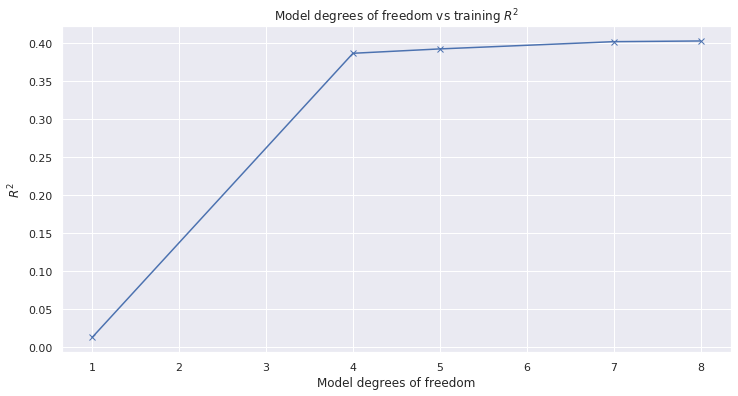

In [69]:
models = [model_1, model_2, model_3, model_4, model_5]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot([model.df_model for model in models], [model.rsquared for model in models], 'x-')
ax.set_xlabel("Model degrees of freedom")
ax.set_title('Model degrees of freedom vs training $R^2$')
ax.set_ylabel("$R^2$");

**What about the test data?**

We added a lot of columns to our training data and must add the same to our test data in order to calculate $R^2$ scores.

In [70]:
# Added features for model 1
# Nothing new to be added

# Added features for model 2
titanic_test = pd.get_dummies(titanic_test, columns=['sex', 'class'], drop_first=True)

# Added features for model 3
titanic_test['sex_male_X_age'] = titanic_test['age'] * titanic_test['sex_male']

# Added features for model 4
titanic_test['sex_male_X_class_Second'] = titanic_test['age'] * titanic_test['class_Second']
titanic_test['sex_male_X_class_Third'] = titanic_test['age'] * titanic_test['class_Third']

# Added features for model 5
titanic_test['age^2'] = titanic_test['age'] **2

**Calculating R^2 scores**

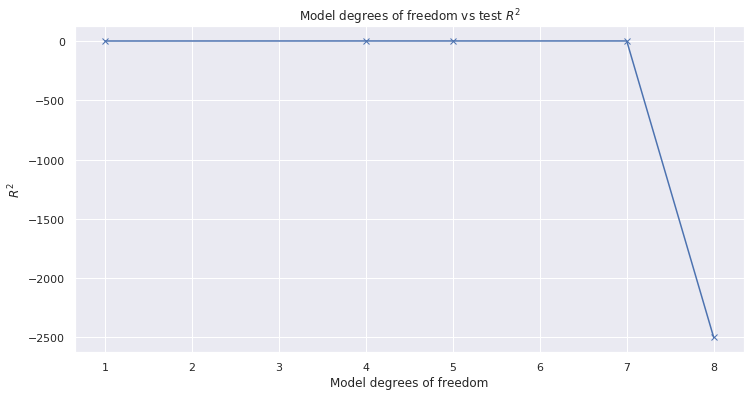

In [71]:
from sklearn.metrics import r2_score

r2_scores = []
y_preds = []
y_true = titanic_test['fare']

# model 1
y_preds.append(model_1.predict(sm.add_constant(titanic_test['age'])))

# model 2
y_preds.append(model_2.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 'class_Third']])))

# model 3
y_preds.append(model_3.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 'class_Third', 
                                                              'sex_male_X_age']])))

# model 4
y_preds.append(model_4.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 'class_Third', 
                                                              'sex_male_X_age', 'sex_male_X_class_Second', 
                                                              'sex_male_X_class_Third']])))

# model 5
y_preds.append(model_5.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 
                                                              'class_Third', 'sex_male_X_age', 
                                                              'sex_male_X_class_Second', 
                                                              'sex_male_X_class_Third', 'age^2']])))

for y_pred in y_preds:
    r2_scores.append(r2_score(y_true, y_pred))
    
models = [model_1, model_2, model_3, model_4, model_5]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot([model.df_model for model in models], r2_scores, 'x-')
ax.set_xlabel("Model degrees of freedom")
ax.set_title('Model degrees of freedom vs test $R^2$')
ax.set_ylabel("$R^2$");

## Regression Assumptions. Should We Even Regress Linearly?

![linear regression](../fig/linear_regression.png)

**Question**: What are the assumptions of a linear regression model? 

We find that the answer to this question can be found on closer examimation of $\epsilon$. What is $\epsilon$? It is assumed that $\epsilon$ is normally distributed with a mean of 0 and variance $\sigma^2$. But what does this tell us?

1. Assumption 1: Constant variance of $\epsilon$ errors. This means that if we plot our **residuals**, which are the differences between the true $Y$ and our predicted $\hat{Y}$, they should look like they have constant variance and a mean of 0. We will show this in our plots.
2. Assumption 2: Independence of $\epsilon$ errors. This again comes from the distribution of $\epsilon$ that we decide beforehand.
3. Assumption 3: Linearity. This is an implicit assumption as we claim that Y can be modeled through a linear combination of the predictors. **Important Note:** Even though our predictors, for instance $X_2$, can be created by squaring or cubing another variable, we still use them in a linear equation as shown above, which is why polynomial regression is still a linear model.
4. Assumption 4: Normality. We assume that the $\epsilon$ is normally distributed, and we can show this in a histogram of the residuals.

**Exercise**: Calculate the residuals for model 5, our most recent model. Optionally, plot and histogram these residuals and check the assumptions of the model.

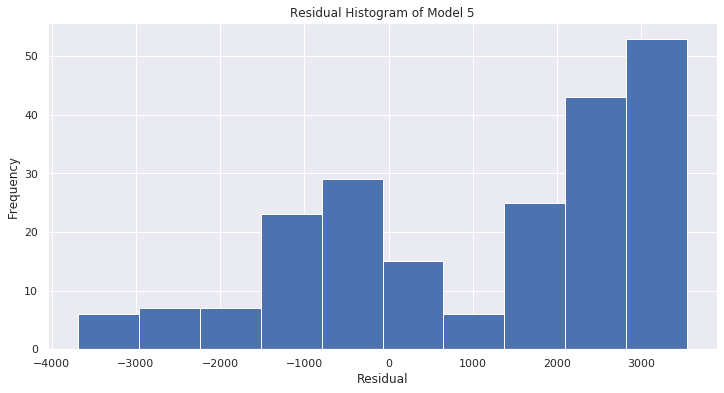

In [73]:
# your code here
y_pred = model_5.predict(sm.add_constant(titanic_test[['age', 'sex_male', 'class_Second', 
                                                              'class_Third', 'sex_male_X_age', 
                                                              'sex_male_X_class_Second', 
                                                              'sex_male_X_class_Third', 'age^2']]))
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(y_true - y_pred)
ax.set_xlabel("Residual")
ax.set_title("Residual Histogram of Model 5")
ax.set_ylabel("Frequency")

**What can you say about the assumptions of the model?**

----------------
### End of Standard Section
---------------

## Extra: Visual exploration of predictors'  correlations

The dataset for this problem contains 10 simulated predictors and a response variable. 

In [74]:
# read in the data 
data = pd.read_csv('data/dataset3.txt')
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.488866,0.488866,0.488866,0.078913,0.098292,0.144871,0.065302,0.250225,-0.392509,-0.501255,0.625915
1,0.146479,0.146479,0.146479,0.022562,0.088052,0.104879,0.082436,0.332836,-0.178366,-0.061798,0.058947
2,0.525450,0.525450,0.525450,-0.157520,-0.328685,-0.246146,-0.233882,0.054153,-0.010547,0.393186,-0.176577
3,0.351241,0.351241,0.351241,-0.062256,-0.096287,-0.033425,-0.088843,-0.475510,-0.066429,-0.249999,0.154168
4,-0.168068,-0.168068,-0.168068,-0.080250,-0.155529,-0.099511,-0.106430,-0.203144,0.194485,-0.037681,-0.288597


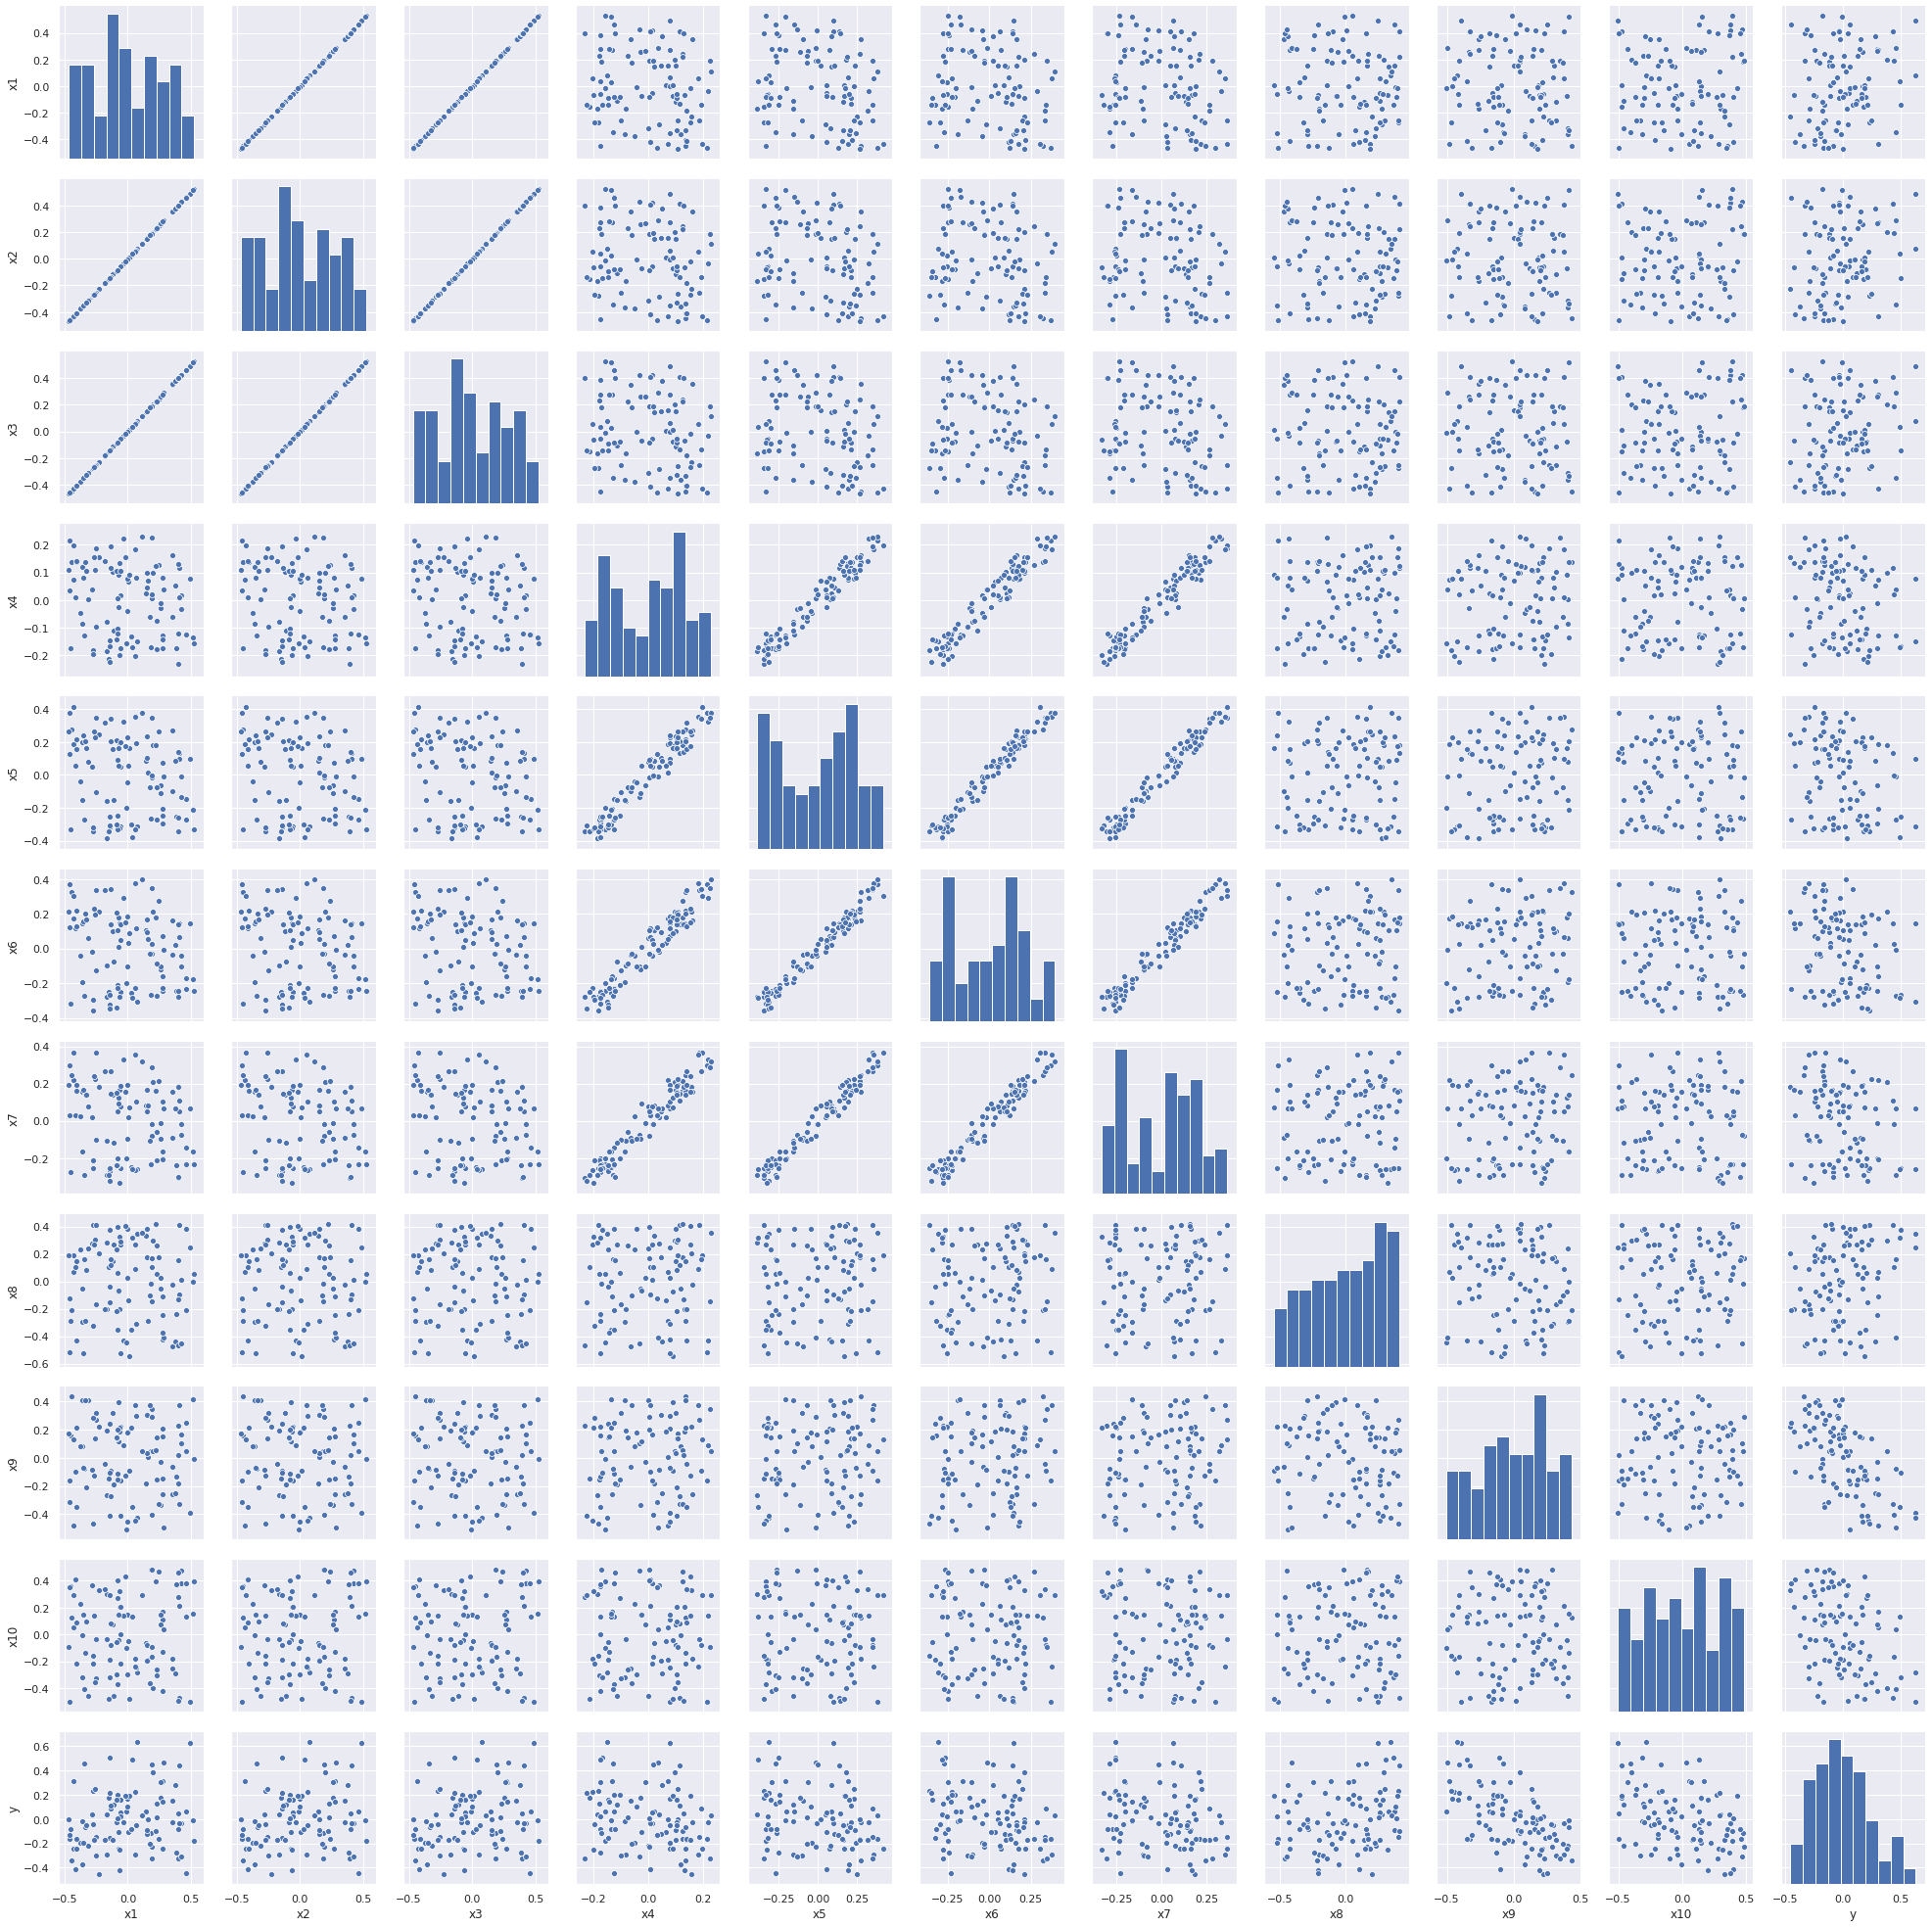

In [75]:
# this effect can be replicated using the scatter_matrix function in pandas plotting
sns.pairplot(data);

Predictors x1, x2, x3 seem to be perfectly correlated while predictors x4, x5, x6, x7 seem correlated.

In [76]:
data.corr()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
x1,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x2,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x3,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x4,-0.189945,-0.189945,-0.189945,1.000000,0.974279,0.964344,0.969540,0.058516,0.108294,-0.010416,-0.225856
x5,-0.232439,-0.232439,-0.232439,0.974279,1.000000,0.982785,0.982227,0.080342,0.126004,-0.012399,-0.257433
x6,-0.215623,-0.215623,-0.215623,0.964344,0.982785,1.000000,0.976308,0.079547,0.123368,-0.021029,-0.261228
x7,-0.228322,-0.228322,-0.228322,0.969540,0.982227,0.976308,1.000000,0.074004,0.112241,-0.022023,-0.235921
x8,-0.047643,-0.047643,-0.047643,0.058516,0.080342,0.079547,0.074004,1.000000,-0.133182,0.052151,0.238538
x9,-0.061022,-0.061022,-0.061022,0.108294,0.126004,0.123368,0.112241,-0.133182,1.000000,0.006923,-0.607845
x10,0.050977,0.050977,0.050977,-0.010416,-0.012399,-0.021029,-0.022023,0.052151,0.006923,1.000000,-0.406231


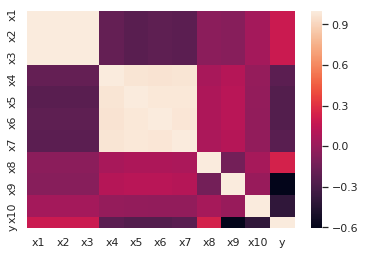

In [77]:
sns.heatmap(data.corr())

## Extra: A Handy Matplotlib Guide

![](https://i.imgur.com/XTzSuoR.png)
source: http://matplotlib.org/faq/usage_faq.html

See also [this](http://matplotlib.org/faq/usage_faq.html) matplotlib tutorial.

![violin plot](../fig/violin.png)

See also [this](https://mode.com/blog/violin-plot-examples) violin plot tutorial.

---